In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.manifold import TSNE
from protein_lm.modeling.scripts.infer import PTMMamba


plot_settings = {'ytick.labelsize': 16,
                        'xtick.labelsize': 16,
                        'font.size': 22,
                        'figure.figsize': (8, 5),
                        'axes.titlesize': 22,
                        'axes.labelsize': 18,
                        'lines.linewidth': 2,
                        'lines.markersize': 3,
                        'legend.fontsize': 11,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'}
plt.style.use(plot_settings)
# Set the seaborn style and font scale for publication
# Set the seaborn style and font scale for publication
# sns.set(style="whitegrid", font_scale=1.2, )
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16})


seed = 7
np.random.seed(seed)

df = pd.read_csv('../binding_site_prediction/data/ptm_data.csv')
ckpt_path = "/workspace/ckpt/bi_mamba-esm-ptm_token_input/best.ckpt"



mamba = PTMMamba(ckpt_path,device='cuda:0')
# random sample of 10 rows 


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>


In [2]:
import pandas as pd

df = pd.read_csv('../binding_site_prediction/data/ptm_data.csv')
df['ptm_seq'][2]

'MQWLRVRESPGEATGHRVTMGTAALGPVWAALLLFLLMCEIPMVELTFDRAVASGCQRCCDSEDPLDPAHVSSASSSGRPHALPEIRPYI<N-linked (GlcNAc...) asparagine>ITILKGDKGDPGPMGLPGYMGREGPQGEPGPQGSKGDKGEMGSPGAPCQKRFFAFSVGRKTALHSGEDFQTLLFERVFVNLDGCFDMATGQFAAPLRGIYFFSLNVHSWNYKETYVHIMHNQKEAVILYAQPSERSIMQSQSVMLDLAYGDRVWVRLFKRQRENAIYSNDFDTYITFSGHLIKAEDD'

In [3]:
ptm_sequences_df = df.sample(10)



# Extracting sequences from wt_seq and ptm_seq columns
wt_sequences = ptm_sequences_df['wt_seq'].tolist()
ptm_sequences = ptm_sequences_df['ptm_seq'].tolist()

# Function to get embeddings and reduce dimensionality using t-SNE
def get_tsne_embeddings(sequences):
    embeddings = []
    for seq in sequences:
        embeddings.append(mamba(seq).hidden_states[0].mean(dim=0).cpu().numpy())
    embeddings = np.array(embeddings)
    tsne = TSNE(n_components=2, random_state=42,perplexity=5)
    tsne_embeddings = tsne.fit_transform(embeddings)
    return tsne_embeddings
# Get t-SNE embeddings for both wt_seq and ptm_seq
tsne_embeddings = get_tsne_embeddings(wt_sequences+ptm_sequences)
# Combine data for visualization
data = pd.DataFrame(tsne_embeddings, columns=['tsne1', 'tsne2'])
data['Type'] = ['Wild-type Sequence']*len(wt_sequences) + ['PTM Sequence']*len(ptm_sequences)



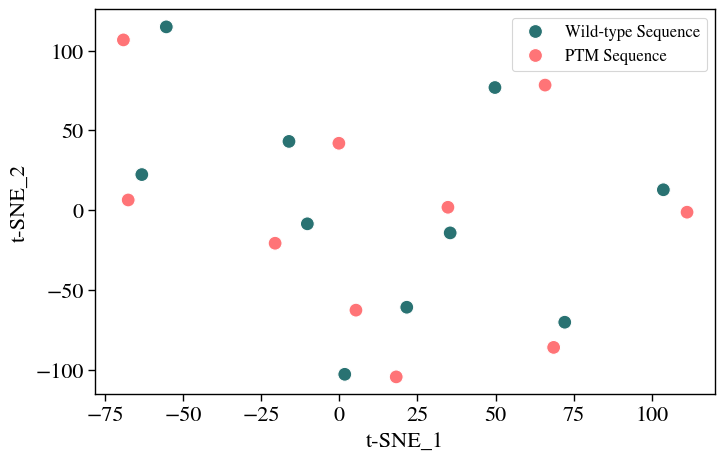

In [9]:
#fecc00 , #008000 colors
sns.scatterplot(x='tsne1', y='tsne2', hue='Type', data=data, palette=['#297272', '#ff7477'], s=100)
plt.legend(fontsize=12)
plt.xlabel('t-SNE_1', fontsize=16)
plt.ylabel('t-SNE_2', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


# plt.title('t-SNE Visualization of Sequence Embeddings')
plt.show()

In [11]:
token_embeddings = mamba.model.backbone.embedding.weight.cpu().detach().numpy()[8:]
print(f"Shape of token embeddings: {token_embeddings.shape}")
labels = mamba.tokenizer.ids_to_tokens[8:]
tokens_to_remove = ["X", "PTM", "B", "U", "Z", "O"]
idxs_to_remove = [
    labels.index(label) for  label in labels if label in tokens_to_remove
]
# remove the token embeddings from token_embeddings based on idxs_to_remove
token_embeddings = np.delete(token_embeddings, idxs_to_remove, axis=0)
labels = [label for label in labels if label not in tokens_to_remove]
# the labels of the tokens are mamba.tokenizer.ids_to_tokens
print(f"Number of tokens: {len(labels)}")
print(labels)
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(token_embeddings)
# plot the embeddings and their labels



Shape of token embeddings: (51, 768)
Number of tokens: 45
['L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C', '<N-linked (GlcNAc...) asparagine>', '<Pyrrolidone carboxylic acid>', '<Phosphoserine>', '<Phosphothreonine>', '<N-acetylalanine>', '<N-acetylmethionine>', '<N6-acetyllysine>', '<Phosphotyrosine>', '<S-diacylglycerol cysteine>', '<N6-(pyridoxal phosphate)lysine>', '<N-acetylserine>', '<N6-carboxylysine>', '<N6-succinyllysine>', '<S-palmitoyl cysteine>', "<O-(pantetheine 4'-phosphoryl)serine>", '<Sulfotyrosine>', '<O-linked (GalNAc...) threonine>', '<Omega-N-methylarginine>', '<N-myristoyl glycine>', '<4-hydroxyproline>', '<Asymmetric dimethylarginine>', '<N5-methylglutamine>', '<4-aspartylphosphate>', '<S-geranylgeranyl cysteine>', '<4-carboxyglutamate>']


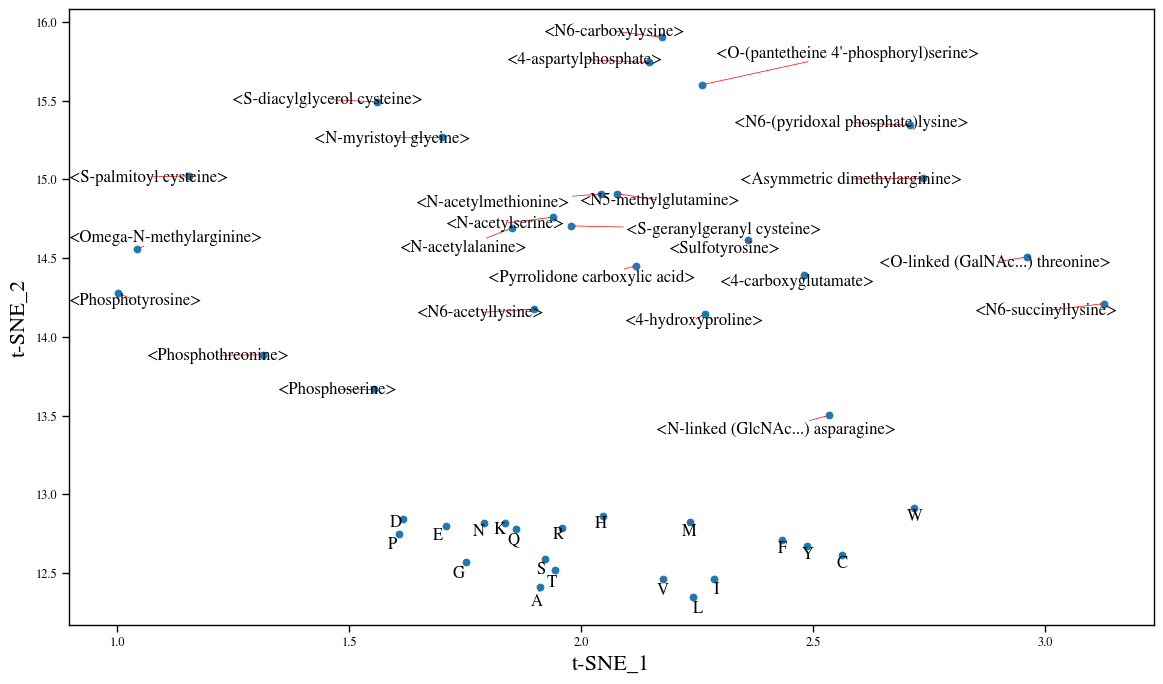

In [12]:
from adjustText import adjust_text  # Import adjust_text from adjustText library

plt.figure(figsize=(14, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1])

# Annotate each point with its label
annotations = [plt.annotate(label, (tsne_embeddings[i, 0], tsne_embeddings[i, 1]), alpha=1, size=12)
               for i, label in enumerate(labels)]

# Use adjust_text to automatically adjust label positions
adjust_text(annotations, arrowprops=dict(arrowstyle="->", color='red', lw=0.5))
plt.xlabel('t-SNE_1', fontsize=16)
plt.ylabel('t-SNE_2', fontsize=16)
plt.show()